In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import matplotlib as mpl
from typing import List
import pandas as pd

# Neural Modelling exercise 2: Prediction learning
Hand-in by Friday, 8.11.24 (midnight) to neuralmodelling24@gmail.com
If you are handing in as a two person team, make sure to put both of your
names on your solution (please hand in only one report per team). Besides your
responses to the questions in text form, your submission should contain your
code. You could e.g. link to a Github repo or submit your report as a Jupyter
notebook.


## Conditioning (Lecture 2)

1. Simulate data for each of the following conditioning paradigms:

    - Blocking
    - Inhibitory conditioning
    - Overshadowing
    - Secondary conditioning
    - Explaining away
    
    To do this, generate arrays which correspond to the sequences of presented
    stimuli and the sequences of presented rewards (ignore time within a trial
    for this, each entry is one trial). Also generate an idealised sequence of
    expectations of rewards of the animal (the expectation occurs after the
    presentation of the CS but before the potential presentation of a reward).
2. Now use the Rescorla-Wagner rule to learn these expectations, based on
the stimulus and reward vectors you generated. 
3. For which paradigms do your learned expectations qualitatively agree with
your idealised predictions? For the non-matching paradigms, speculate
why the Rescorla-Wagner rule failed to produce the correct expectations.

In [2]:
cmap = mpl.colormaps["tab10"]


def v(w: np.ndarray, u: np.ndarray) -> float:
    """compute expected value

    Args:
        w (np.ndarray): (n_stimuli)
        u (np.ndarray): (n_stimuli)

    Returns:
        float: expected value
    """
    return np.dot(w, u)


# TODO: add annotation, when is it training / trials?
def plot_stimulus(stim_0, stim_1, reward, n_pretraining: int = 0):
    fig, ax = plt.subplots(figsize = (8, 5))
    mapable = ax.imshow(np.stack([stim_0, stim_1, reward]), cmap = "cividis", vmin = 0, vmax = 1)

    ax.axvline(n_pretraining, linestyle = "--", color = "gray", label = "training start")
    ax.legend(loc = "center left", bbox_to_anchor = (1.2, 0.5))

    ax.set_aspect(5)
    ax.set_yticks(np.arange(0, 3), labels = ["Stimulus 0", "Stimulus 1", "Reward"])
    ax.set_xlabel("trials")
    fig.colorbar(mapable, location = "right", label = "stimulus strength", fraction = 0.01)
    ax.set_title("Stimulus")


# TODO: add comments what the function does
def learn(u: np.ndarray, reward, learning_rate) -> Tuple[np.ndarray, np.ndarray]:
    v_pred = np.empty(len(u))
    w = np.zeros_like(u)
    for i in range(u.shape[0] - 1):
        v_pred[i] = v(w[i], u[i])
        delta = learning_rate * (reward[i] - v_pred[i]) * u[i]
        w[i + 1] = w[i] + delta

    v_pred[-1] = v(w[-1], u[-1])

    return w, v_pred


def test_trial(w):
    expected_reward = v(np.array([[0, 0], [0, 1], [1, 0], [1, 1]]), w).reshape(2, 2)

    print("expected reward in test trial")
    print(pd.DataFrame(expected_reward, columns = ["stim_0 = 0", "stim_0 = 1"], index = ["stim_1 = 0", "stim_1 = 1"]))


def plot_riscorla_wagner(
        w,
        v_pred: np.ndarray,
        v_exp: List = None,
        v_exp_labels: List[str] = [],
        expectations: List[np.ndarray] = [],
        title: str = "",
        n_pretraining = 0
):
    fig, axs = plt.subplots(nrows = 2, sharex = True)

    for i in range(w.shape[1]):
        axs[0].plot(w[:, i], label = rf"$w_{i}$")

    for idx, expect in enumerate(expectations):
        axs[0].plot(expect, label = rf"expected: $w_{idx}$", linestyle = "--", color = cmap(w.shape[1] + idx))

    axs[0].set_title(title)

    axs[0].set_ylabel("weights")

    axs[1].plot(v_pred, label = "predicted reward, r")

    if v_exp is not None:
        for exp, lab in zip(v_exp, v_exp_labels):
            axs[1].plot(exp, label = lab, linestyle = "--")

    axs[1].set_xlabel("trials")
    axs[1].set_ylabel("reward")

    axs[0].axvline(n_pretraining, linestyle = "--", color = "gray", label = "training start")
    axs[1].axvline(n_pretraining, linestyle = "--", color = "gray", label = "training start")

    axs[0].legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    axs[1].legend(loc = "center left", bbox_to_anchor = (1, 0.5))

    plt.show()


n_pretraining = 50
n_trials = 100 + 1
learning_rate = 0.15

### Blocking

The **blocking paradigm** is a phenomenon where prior learning interferes with new learning about a stimulus when that stimulus is paired with an already familiar cue.

Phases:
(1) Pre-training: a stimulus A, $s_A$, is associated with the reward, $r$.
(2) Training: $s_A$ is presented alongside a new stimulus B, $s_B$. Both cues continue to predict the reward, $r$.
(3) Result: conditioned stimulus A, $s_A$, continues to predict the reward, while conditioned stimulus B, $s_B$, is not associated with the reward. The previously learned stimulus A essentially “blocks” stimulus B from forming a significant association with the reward.


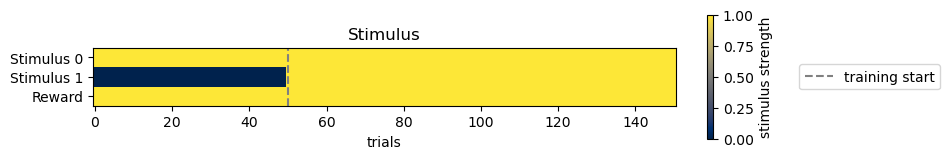

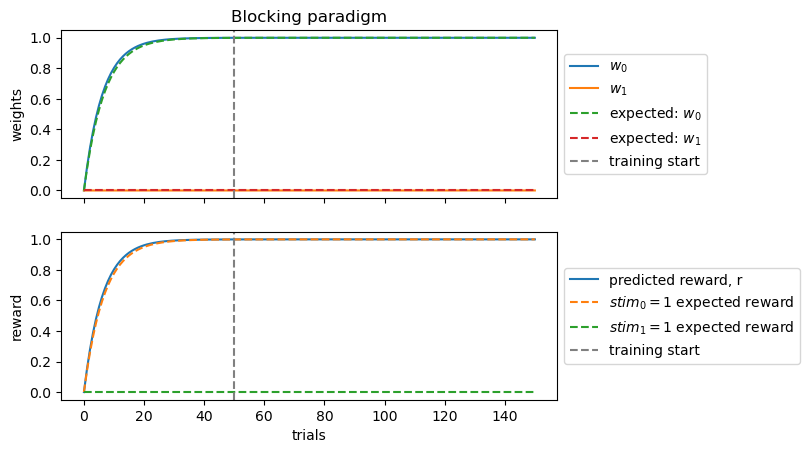

expected reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0    0.000000    0.000148
stim_1 = 1    0.999852    1.000000


In [3]:
# 1st stimulus is constant during pretraining and trials
stim_0 = np.ones(n_pretraining + n_trials)

# 2nd stimulus is constant during trials only
stim_1 = np.ones_like(stim_0)
stim_1[:n_pretraining] = 0

# Reward is given always
reward = np.ones_like(stim_0)

# Final stimulus matrix
u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

plot_stimulus(stim_0, stim_1, reward, n_pretraining)

# Expected weights
expect_0 = 1 - np.exp(-np.arange(n_pretraining + n_trials) * learning_rate)
expect_1 = np.zeros(n_pretraining + n_trials)
# Expected reward
v_exp_0 = 1 - np.exp(-np.arange(n_pretraining + n_trials) * learning_rate)
v_exp_1 = np.zeros(n_pretraining + n_trials)

# Apply Rescorla-Wagner
w, v_pred = learn(u, reward, learning_rate)

plot_riscorla_wagner(
    w = w,
    v_pred = v_pred,
    v_exp = [v_exp_0, v_exp_1],
    v_exp_labels = [rf"$stim_0=1$ expected reward", rf"$stim_1=1$ expected reward"],
    expectations = [expect_0, expect_1],
    title = "Blocking paradigm",
    n_pretraining = n_pretraining
)
test_trial(w[-1])

The table shows expected reward in the test trial for all stimulus combinations. When both stimuli are not presented or when only the 1st stimulus is presented, no reward is expected. When the 2nd stimulus is presented (whether in combination with stimulus 1 or not), the full reward is expected.

In the case of blocking paradigm, the Rescorla-Wagner rule predicts the expected result: the first stimulus is associated with the cue, while the second stimulus fails to form this connection.

### Inhibitory Conditioning

The **inhibitory conditioning** pairs the stimulus signal with the absence of a reward.

Phases:
(1) Training: stimulus A, $s_A$, and stimulus B, $s_B$, is presented. The $s_A$ cue predicts reward, while both cues predict no reward.
(2) Result: conditioned stimulus A, $s_A$, predicts the reward, while conditioned stimulus B, $s_B$, predicts negative reward.

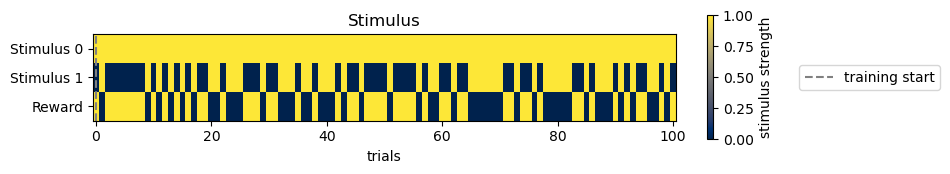

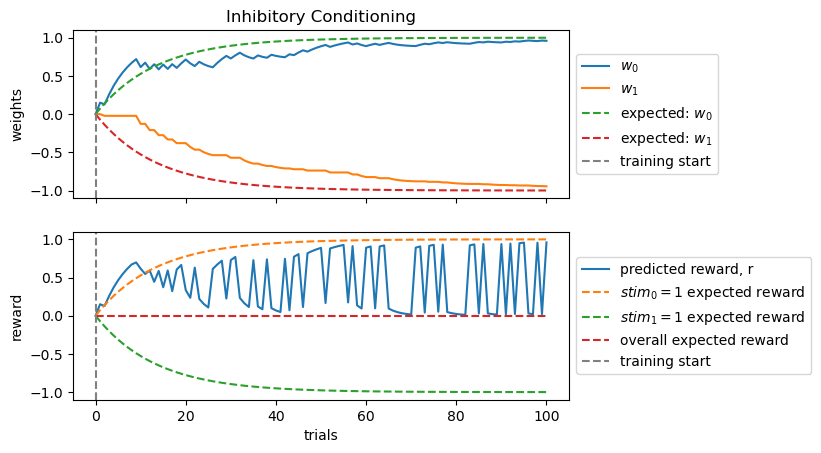

expected reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0    0.000000   -0.944756
stim_1 = 1    0.959466    0.014710


In [4]:
# 1st stimulus is constantly presented in all trials
stim_0 = np.ones(n_trials)
# 2nd stimulus is randomly presented in some of the trials
np.random.seed(1)
stim_1 = np.random.sample(n_trials) > 0.5

# Reward is given when the 2nd stimulus is not presented
reward = (~stim_1).astype(int)

# Final stimulus matrix
u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

plot_stimulus(stim_0, stim_1, reward)

# Expected result
expect_0 = 1 - np.exp(-np.arange(n_trials) * learning_rate * 0.5)
expect_1 = np.exp(-np.arange(n_trials) * learning_rate * 0.5) - 1
# Expected reward
v_exp_0 = 1 - np.exp(-np.arange(n_trials) * learning_rate * 0.5)
v_exp_1 = np.exp(-np.arange(n_trials) * learning_rate * 0.5) - 1
v_exp = v_exp_0 + v_exp_1

# Apply Rescorla-Wagner
w, v_pred = learn(u, reward, learning_rate)

plot_riscorla_wagner(
    w = w,
    v_pred = v_pred,
    v_exp = [v_exp_0, v_exp_1, v_exp],
    v_exp_labels = [rf"$stim_0=1$ expected reward", rf"$stim_1=1$ expected reward", "overall expected reward"],
    expectations = [expect_0, expect_1],
    title = "Inhibitory Conditioning"
)
test_trial(w[-1])  ## TODO: change to rewards, not weight!!!

In the case of inhibitory conditioning, the Rescorla-Wagner rule predicts the expected result: only the first stimulus predicts the reward ($stim_0 = 0$, $stim_1 = 1$ in the table above); the second stimulus, on the other hand, predicts negative reward ($stim_0 = 1$, $stim_1 = 0$ in the table above).

In [5]:
# Since the process is stochastic, we sample 10k trials

w_stack = []
v_exp_stack = []
for _ in range(10000):
    stim_0 = np.ones(n_trials)
    stim_1 = np.random.sample(n_trials) > 0.5
    reward = (~stim_1).astype(int)

    u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

    w, v_exp = learn(u, reward, learning_rate)
    w_stack.append(w)
    v_exp_stack.append(v_exp)

w_stack = np.stack(w_stack)
v_exp_stack = np.stack(v_exp_stack)

ValueError: x and y must be the same size

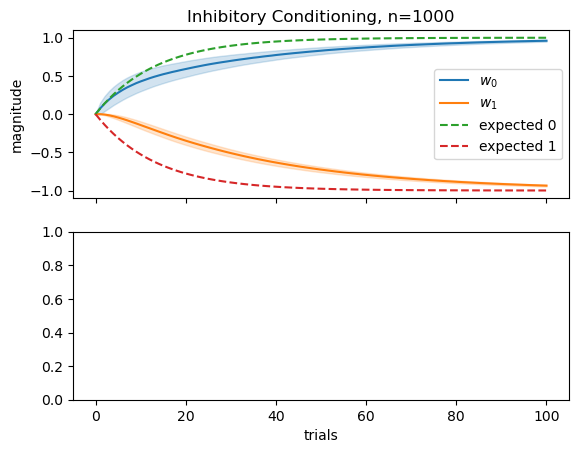

In [6]:
mean = w_stack.mean(axis = 0)
std = w_stack.std(axis = 0)

fig, ax = plt.subplots(nrows = 2, sharex = True)
ax[0].plot(mean[:, 0], c = cmap(0), label = rf"$w_0$")
ax[0].plot(mean[:, 1], c = cmap(1), label = rf"$w_1$")

ax[0].fill_between(np.arange(len(mean)), mean[:, 0] - std[:, 0], mean[:, 0] + std[:, 0], alpha = 0.2, color = cmap(0))
ax[0].fill_between(np.arange(len(mean)), mean[:, 1] - std[:, 1], mean[:, 1] + std[:, 1], alpha = 0.2, color = cmap(1))

expect_0 = 1 - np.exp(-np.arange(n_trials) * learning_rate * 0.5)
expect_1 = np.exp(-np.arange(n_trials) * learning_rate * 0.5) - 1
ax[0].plot(expect_0, linestyle = "--", color = cmap(2), label = "expected 0")
ax[0].plot(expect_1, linestyle = "--", color = cmap(3), label = "expected 1")

ax[0].set_title("Inhibitory Conditioning, n=1000")
ax[0].legend()
ax[0].set_ylabel("magnitude")
ax[1].set_xlabel("trials")

mean = v_exp_stack.mean(axis = 0)
std = v_exp_stack.std(axis = 0)

for v_ in v_exp_stack[:50]:
    ax[1].scatter(np.arange(100), v_, color = cmap(0), alpha = 0.1, s = 2)

ax[1].plot(mean, label = "mean")
ax[1].fill_between(np.arange(len(mean)), mean - std, mean + std, alpha = 0.2, color = cmap(0), label = "std")
ax[1].legend()
ax[1].set_ylabel("expected reward")
plt.show()

The results resemble what we see in the case of a single trial: the weights for stimulus 0 approach 1, while the weights for stimulus 1 approach -1. The mean of predicted reward, in this case, approaches 0.5 with a standard deviation of 1 (because the predicted reward is either zero or one with a 50/50 distribution).

In [ ]:
v_test = np.stack([w @ np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T for w in w_stack])
v_test = v_test.reshape(-1, 100, 2, 2)

bins = np.linspace(-1, 1, 51)

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (9, 8), sharex = True, sharey = True)
counts = np.stack([np.histogram(v_test[..., i, 0, 0], bins = bins)[0] for i in range(v_test.shape[1])])
mappable = axs[0, 0].imshow(counts.T[::-1], extent = (0, v_test.shape[1], -1, 1), aspect = "auto")
axs[0, 0].set_title("stim_0 = 0, stim_1 = 0")
counts = np.stack([np.histogram(v_test[..., i, 0, 1], bins = bins)[0] for i in range(v_test.shape[1])])
axs[0, 1].imshow(counts.T[::-1], extent = (0, v_test.shape[1], -1, 1), aspect = "auto")
axs[0, 1].set_title("stim_0 = 0, stim_1 = 1")
counts = np.stack([np.histogram(v_test[..., i, 1, 0], bins = bins)[0] for i in range(v_test.shape[1])])
axs[1, 0].imshow(counts.T[::-1], extent = (0, v_test.shape[1], -1, 1), aspect = "auto")
axs[1, 0].set_title("stim_0 = 1, stim_1 = 0")
counts = np.stack([np.histogram(v_test[..., i, 1, 1], bins = bins)[0] for i in range(v_test.shape[1])])
axs[1, 1].set_title("stim_0 = 1, stim_1 = 1")
axs[1, 1].imshow(counts.T[::-1], extent = (0, v_test.shape[1], -1, 1), aspect = "auto")

fig.suptitle("Development of Expected Reward over Trials")
fig.supxlabel("Trials")
fig.supylabel("Expected Reward")
fig.colorbar(mappable, ax = axs, label = "count")
plt.show()

We now computed the expected reward at each training step across all sampled trial sequences. This means, in each case we look at how the animal would predict a reward if it was presented with a particular stimulus (e.g. $stim_0=1$ and $stim_1=0$). Again, because this process is stochastic we get a distribution of expected rewards.  

For each tile we can observe the mode approaching the expected reward in the test trial inferred by the Rescorla-Wagner rule.

### Overshadowing

In overshadowing, the more intense or attention-grabbing cue dominates the learning process, preventing the other cue from becoming strongly associated with the outcome.

Phases:
(1) Training: stimuli A, $s_A$, and B, $s_B$, are presented together with a reward, $r$. However, stimulus A is very clear while stimulus B is quite faint.
(2) Result: both stimuli predict reward, however, their weights differ depending on their individual salience.

In [ ]:
# Both stimuli are constantly presented in all trials, together with the reward
stim_0 = np.ones(n_trials)
stim_1 = np.ones(n_trials)
reward = np.ones(n_trials)

u = np.stack([stim_0, stim_1]).T

plot_stimulus(stim_0, stim_1, reward)

# Expected weights
expect_0 = (1 - np.exp(-np.arange(n_trials) * learning_rate)) * 0.7
expect_1 = (1 - np.exp(-np.arange(n_trials) * learning_rate)) * 0.3
# Expected reward
v_exp_0 = (1 - np.exp(-np.arange(n_trials) * learning_rate)) * 0.7
v_exp_1 = (1 - np.exp(-np.arange(n_trials) * learning_rate)) * 0.3
v_exp = v_exp_0 + v_exp_1

w, v_pred = learn(u, reward, learning_rate = np.array([learning_rate * 0.7, learning_rate * 0.3]))

plot_riscorla_wagner(
    w = w,
    v_pred = v_pred,
    v_exp = [v_exp_0, v_exp_1, v_exp],
    v_exp_labels = [rf"$stim_0=1$ expected reward", rf"$stim_1=1$ expected reward", "overall expected reward"],
    expectations = [expect_0, expect_1],
    title = "Overshadowing"
)
test_trial(w[-1])

In the case of overshadowing, the Rescorla-Wagner rule predicts the expected result: both stimuli are associated with the reward with strength that corresponds to their salience (0.7 for stimulus 0, and 0.3 for stimulus 1). Salience values were chosen arbitrarily and in such a way that they sum up to one.

### Secondary Conditioning

The secondary conditioning paradigm is a form of learning where a neutral stimulus (Stimulus B) becomes associated with a conditioned response through its association with a previously conditioned stimulus (Stimulus A), rather than through direct pairing with an unconditioned stimulus.

Phases:
(1) Pre-training (first-order conditioning): associate stimulus A, $s_A$, with the reward, $r$.
(2) Training (second-order conditioning): associate a new stimulus B, $s_B$, with $s_A$.
(3) Result: $s_B$ predicts $s_A$, which in turn predicts $r$.

In [ ]:
# Stimulus 0 is constantly on
stim_0 = np.ones(n_pretraining + n_trials)
# Stimulus 1 is off during pre-training and only on during training
stim_1 = np.ones(n_pretraining + n_trials)
stim_1[:n_pretraining] *= 0

# Reward is presented only during pre-training, to associate
# stimulus 0 with the reward
reward = np.zeros(n_pretraining + n_trials)
reward[:n_pretraining] = 1

u = np.stack([stim_0, stim_1]).T

plot_stimulus(stim_0, stim_1, reward, n_pretraining = n_pretraining)

# Expected weights
expect_0 = 1 - np.exp(-np.arange(n_pretraining + n_trials) * learning_rate)
expect_1 = np.zeros_like(expect_0)
expect_1[n_pretraining:] = 1 - np.exp(-np.arange(n_trials) * learning_rate)
# Expected rewards
v_exp_0 = 1 - np.exp(-np.arange(n_pretraining + n_trials) * learning_rate)
v_exp_1 = np.zeros(n_pretraining + n_trials)
v_exp_1[n_pretraining:] = 1 - np.exp(-np.arange(n_trials) * learning_rate)
v_exp = v_exp_0

w, v_pred = learn(u, reward, learning_rate)
# plot_riscorla_wagner(w=w, v_exp=v_exp, expectations = [expect_0, expect_1], title = "Secondary Conditioning")

plot_riscorla_wagner(
    w = w,
    v_pred = v_pred,
    v_exp = [v_exp_0, v_exp_1, v_exp],
    v_exp_labels = [rf"$stim_0=1$ expected reward", rf"$stim_1=1$ expected reward", "overall expected reward"],
    expectations = [expect_0, expect_1],
    title = "Secondary conditioning",
    n_pretraining = n_pretraining
)

test_trial(w[-1])

In the case of secondary conditioning, the Rescorla-Wagner rule does not predict the expected result. We expected that stimulus 0 is associated with the reward during the pre-training phase; however, it is unclear what would happen to this association later on (i.e., whether the animal would forget it during the training phase or not), so we chose the alternative that the association between stimulus 0 and the reward is not forgotten. In the case of the stimulus 1, we expect that it will become associated with the reward during the training phase in the manner $stim_1 \to stim_0 \to \text{reward}$.

However, the Rescorla-Wagner rule does not support secondary conditioning (it only creates association from stimulus to reward and not stimulus to another stimulus), so when both stimuli are presented with no reward, the weights for both stimuli decrease to predict no reward. The weight for stimulus 0 decreases to 0.5, while the weight for stimulus 1 becomes negative (-0.5).

### Explaining Away

In the explaining away paradigm, the animal is presented with two stimuli and a reward, however, later it is revealed that only one of the stimuli is enough to predict the reward.

Phases:
(1) Pre-training: both stimuli $0$ and $1$ are associated with the reward.
(2) Training: stimulus $1$ is removed, and only stimulus $0$ is presented with the reward.
(3) Result: there is no association between stimulus $1$ and the reward, because stimulus $0$ alone is able to predict the reward.

In [ ]:
# Stimulus 0 is constantly present 
stim_0 = np.ones(n_pretraining + n_trials)
# Stimulus 1 is present only during pre-training
stim_1 = np.ones(n_pretraining + n_trials)
stim_1[n_pretraining:] = 0

# Reward is constant
reward = np.ones_like(stim_0)

u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

plot_stimulus(stim_0, stim_1, reward)

# Expected weight
expect_0 = np.zeros(n_pretraining + n_trials)
expect_0[:n_pretraining] = 0.5 - 0.5 * np.exp(-np.arange(n_pretraining) * learning_rate)
expect_0[n_pretraining:] = 1 - 0.5 * np.exp(-np.arange(n_trials) * learning_rate)
expect_1 = np.zeros(n_pretraining + n_trials)
expect_1[:n_pretraining] = 0.5 - 0.5 * np.exp(-np.arange(n_pretraining) * learning_rate)
expect_1[n_pretraining:] = (0.5 * np.exp(-np.arange(n_trials) * learning_rate))
# Expected reward
v_exp_0 = expect_0
v_exp_1 = expect_1
v_exp = v_exp_0 + v_exp_1

w, v_pred = learn(u, reward, learning_rate)

plot_riscorla_wagner(
    w = w,
    v_pred = v_pred,
    v_exp = [expect_0, expect_1, v_exp],
    v_exp_labels = [rf"$stim_0=1$ expected reward", rf"$stim_1=1$ expected reward", "overall expected reward"],
    expectations = [expect_0, expect_1],
    title = "Explaining Away"
)
test_trial(w[-1])

## Extinction (Lecture 3)

In an extinction protocol, animals repeatedly encounter a previously learned
CS, but without receiving the corresponding punishment. However, in certain
conditions, the learned association can resurface. We will work towards one
way of modelling this, using state-based inference. (Remember: A state, or
latent cause, is the context which an animal infers to make predictions about
its environment.)

For this exercise please note that for this exercise we denote `state_0` as the state in which the animal is getting shocked after the tone and `state_1` is the state in which the animal only gets the tone.

In [ ]:
n_pretraining = 50
n_training = 50
n_pause = 30


def plot_belief(belief: np.ndarray):
    # two states -> shocked and not shocked

    fig, ax = plt.subplots()
    ax.axvspan(-0.5, n_pretraining - 0.5, alpha = 0.2, color = cmap(2), label = "pretrain")
    ax.axvspan(
        -0.5 + n_pretraining,
        n_pretraining + n_pretraining - 0.5,
        alpha = 0.2,
        color = cmap(3),
        label = "train",
    )
    ax.axvspan(
        -0.5 + n_pretraining + n_pretraining,
        n_pretraining + n_pretraining + n_pause - 0.5,
        alpha = 0.2,
        color = cmap(4),
        label = "pause",
    )
    ax.axvspan(
        -0.5 + n_pretraining + n_pretraining + n_pause,
        n_pretraining + n_pretraining + n_pause + 1,
        alpha = 0.2,
        color = cmap(5),
        label = "test",
    )
    ax.plot(belief, label = "belief state_0", color = cmap(0))
    ax.plot(1 - belief, label = "belief state_1", color = cmap(1))

    ax.legend()
    ax.set_xlabel("days")
    ax.set_ylabel("belief")

    return fig, ax

- An animal first encounters 50 conditioning trials in a row, then, on the
next day, 50 extinction trials in a row. Finally, after a substantial delay
of 30 days, it encounter the CS again, for one single trial. Design an
appropriate array which could describe the belief of the animal about the
current state of the environment on each trial, right before receiving the
CS. (Hint: How many states do you need? At which points in time do
they change?)

In [ ]:


pretraining = np.ones(n_pretraining)
training = np.zeros(n_training)
test = np.ones(1)
shock = np.concatenate([pretraining, training])
tone = np.concatenate([np.ones_like(pretraining), np.ones_like(training)], )

fig, ax = plt.subplots(figsize = (8, 5))
mapable = ax.imshow(np.stack([tone, shock]), cmap = "cividis", vmin = 0, vmax = 1)
ax.set_aspect(5)
ax.set_yticks(np.arange(0, 2), labels = ["Tone", "Shock"])
ax.set_xlabel("trials")
fig.colorbar(mapable, location = "right", label = "stimulus strength", fraction = 0.009)
ax.set_title("Stimulus")


In [ ]:
after_train_believe = 0.7
p_shocked = np.concatenate(
    [
        np.ones(n_pretraining),
        after_train_believe / 2 * np.cos(np.arange(n_training) / n_training * np.pi)
        + 1
        - (after_train_believe / 2),
        -(after_train_believe - 0.5)
        / 2
        * np.cos(np.arange(n_pause + 1) / n_pause * np.pi)
        + (1 - after_train_believe)
        + (after_train_believe - 0.5) / 2,
    ]
)

fig, ax = plot_belief(p_shocked)
ax.set_title("Expected Behavior")


- Using this belief array, plot the animal’s expectation of receiving the US
after the CS on each trial. (For this part of the exercise, ignore the learning
of the CS-US relationship, assume that the animal perfectly knows the
connection between CS and US for each state).

In [ ]:
perfect_learning = np.concatenate([
    np.ones(n_pretraining),
    np.zeros(n_training + n_pause + 1)
])

fig, ax = plot_belief(perfect_learning)
ax.set_title("Perfect Learning")

The expectation and believe are the same because the expectation of a binary event is the probability of the binary event. 

- Now, rather than assuming our state belief array, we will infer it ourselves
with a simple heuristic. Write a function which takes three inputs: The
state of the previous trial, the similarity of the previous trial to the one
before it in terms of made observations, and the amount of time which
passed since the last trial. Based on these arguments, return a belief over
all states which are under consideration. On the first trial, the animal is
100% certain of being in state 1. (We don’t expect any specific functional
form for this function, but it should qualitatively recreate your belief array
from the first part of this exercise).

In [ ]:
def update_state_0(prev_belief_state_0: np.ndarray, similarity: float, pause: int):
    forget_rate = 0.1
    for _ in range(pause):
        delta = forget_rate * (0.5 - prev_belief_state_0)
        prev_belief_state_0 += delta

    learning_rate = 0.02
    # assume 2 dimensional observation space
    delta = learning_rate * ((similarity - 1) - prev_belief_state_0)
    prev_belief_state_0 += delta

    return prev_belief_state_0


observations = np.stack([tone, shock]).T
state_belief_state_0 = np.empty(n_training + n_pretraining + n_pause + 1)
state_belief_state_0[0] = 1
for i in range(1, n_pretraining + n_training + n_pause + 1):
    # just for displaying purposes -> same thing as just putting in the 30 day pause into update_state_0
    if i >= n_pretraining + n_training:
        similarity = state_belief_state_0[i - 1] + 1
        pause = 1
    else:
        similarity = np.dot(*observations[i - 1: i + 1])
        pause = 0
    state_belief_state_0[i] = update_state_0(
        prev_belief_state_0 = state_belief_state_0[i - 1],
        similarity = similarity,
        pause = pause,
    )

fig, ax = plot_belief(state_belief_state_0)
ax.set_title("Belief with Riscorla-Wagner")

- Finally, maintain a learned association strength between CS and US for
each state separately. Update them after each trial according to the
Rescorla-Wagner rule, but also weigh the magnitude of the update by
the strength of the belief in the state. For simplicity, assume that the
belief about the current state does not change between the beginning and
the end of each trial.

In [ ]:
# Define stimuli
stimulusA = np.ones(n_pretraining + n_training).astype(bool)

# Define rewards
rewards = np.concatenate([
    np.ones(n_pretraining),
    np.zeros(n_training)
]).astype(bool)

In [ ]:
_, ax = plt.subplots(figsize = (8, 5))

plt.imshow([stimulusA, rewards], aspect = "equal")

ax.set_aspect(5)
ax.set_yticks(np.arange(0, 2), labels = ["Stimulus A", "Reward"])
plt.title("Stimulus and reward presentation")

plt.show()

In [ ]:
def update_state_0(prev_belief_state_0: np.ndarray, similarity: float, pause: int):
    forget_rate = 0.1
    for _ in range(pause):
        delta = forget_rate * (0.5 - prev_belief_state_0)
        prev_belief_state_0 += delta

    learning_rate = 0.15
    # assume 2 dimensional observation space
    delta = learning_rate * ((similarity - 1) - prev_belief_state_0)
    prev_belief_state_0 += delta

    return prev_belief_state_0


# stimuli
u = tone
alpha = learning_rate
r = shock

# predicted rewards
vA = np.zeros(shape = (n_pretraining + n_training, 1))
vB = np.zeros(shape = (n_pretraining + n_training, 1))
# weights for state A - tone -> shock
wA = np.zeros(shape = (n_pretraining + n_training, 1))
wB = np.zeros(shape = (n_pretraining + n_training, 1))

# Belief about the state A
state_belief_state_0 = np.empty(n_training + n_pretraining)
state_belief_state_0[0] = 1

observations = np.stack([tone, shock]).T

for i in range(1, n_pretraining + n_training):
    similarity = np.dot(*observations[i - 1: i + 1])
    pause = 0
    state_belief_state_0[i] = update_state_0(
        prev_belief_state_0 = state_belief_state_0[i - 1],
        similarity = similarity,
        pause = pause
    )

    v_exp = np.sum(vA[i - 1])
    delta_w = alpha * (r[i - 1] - v_exp) * u[i - 1]
    wA[i] = wA[i - 1] + delta_w * state_belief_state_0[i]
    vA[i] = wA[i] * u[i]

    # TODO: not sure if correct!!!
    v_exp = np.sum(vB[i - 1])
    delta_w = alpha * (r[i - 1] - v_exp) * u[i - 1]
    wB[i] = wB[i - 1] + delta_w * (1 - state_belief_state_0[i])
    vB[i] = wB[i] * u[i]

In [ ]:
fig, ax = plt.subplots()

ax.plot(wA, label = "Predicted rewards A")
ax.plot(wB, label = "Predicted reward B")

ax.axvspan(-0.5, n_pretraining - 0.5, alpha = 0.2, color = cmap(2), label = "pretrain")
ax.axvspan(
    -0.5 + n_pretraining,
    n_pretraining + n_pretraining - 0.5,
    alpha = 0.2,
    color = cmap(3),
    label = "train"
)
ax.axvspan(
    -0.5 + n_pretraining + n_pretraining,
    n_pretraining + n_pretraining + n_pause - 0.5,
    alpha = 0.2,
    color = cmap(4),
    label = "pause"
)
ax.axvspan(
    -0.5 + n_pretraining + n_pretraining + n_pause,
    n_pretraining + n_pretraining + n_pause + 1,
    alpha = 0.2,
    color = cmap(5),
    label = "test"
)

ax.plot(state_belief_state_0, "--", label = "belief state 0")
ax.plot(1 - state_belief_state_0, "--", label = "belief state 1")
ax.legend()
ax.set_xlabel("days")
ax.set_ylabel("belief")

plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.title("Blocking paradigm")

plt.show()